# AdaBoosting

In [1]:
from preprocessing import *
from aux import *
import matplotlib
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [2]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    columnas_a_encodear = ['tipo_de_sala', 'genero', 'nombre_sede']
    df = encodear_atributos_categoricos(df, columnas_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [3]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [4]:
volver = ['volveria']
columnas = columnillas + volver

In [5]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [6]:
df.shape

(801, 15)

## Entrenamiento

In [7]:
X, y = split_dataset_X_y(df, columnillas)

ada_params = {'n_estimators': np.arange(25, 100),
              'learning_rate': [0.1, 0.2, 0.4, 0.7],
              'algorithm': ['SAMME', 'SAMME.R'],
             }

model_ada = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
        max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state=117)

best_params, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, model_ada, ada_params)

ada_boosting = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    algorithm = best_params['algorithm']
)
ada = apply_stratified_k_fold(X, y, ada_boosting)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8610752056404231
Best params {'n_estimators': 68, 'learning_rate': 0.2, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7549
Fold 1: AUC ROC score is 0.7880
Fold 2: AUC ROC score is 0.8511
Fold 3: AUC ROC score is 0.7995
Fold 4: AUC ROC score is 0.8119
Mean test AUC ROC is: 0.8011


## Métricas

In [8]:
scores = get_scores(ada, X_test, y_test)

AUC ROC : 0.9062
Accuracy : 0.8607
Precision : 0.8769
Recall : 0.9355
F1-Score : 0.8028


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


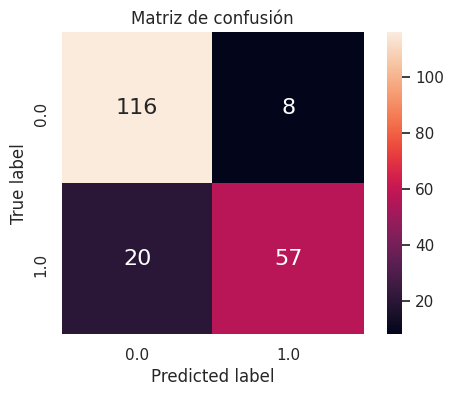

In [9]:
plot_confusion_matrix(y_test, ada.predict(X_test))

## Test Holdout

In [10]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [11]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [12]:
df_resultado = evaluate_holdout(holdout, df_h, ada)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [13]:
df_resultado.to_csv('prediccion/Ada_boosting_resultado_final.csv')

## Preprocesado 2

In [47]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = replace_nulls_column(df, 'edad', 'mediana')
    df = eliminar_features(df, ['amigos', 'parientes'])
    columnas_a_encodear = ['tipo_de_sala', 'genero', 'nombre_sede']
    df = encodear_atributos_categoricos(df, columnas_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [48]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan',
               'edad', 'precio_ticket',
                   'nombre_sede_fiumark_palermo', 
               'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']
columnas_2 = columnas_nuevas + volver

In [49]:
df_2 = preprocesado_2(dataset, columnas_2)

df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,117,0,0,73.5,1,0,1,0,0
1,1,0,0,658,1,0,35.0,2,0,1,0,0
2,0,1,0,794,0,0,31.0,3,0,0,0,0
3,1,0,0,455,0,0,31.0,1,1,0,0,0
4,1,0,0,173,1,0,4.0,2,1,0,0,1


In [50]:
df_2.shape

(801, 12)

## Entrenamiento

In [51]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_nuevas)
model_ada_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(
        max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state=117)

best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, model_ada_2, 
                                                                                        ada_params)

ada_boosting_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117,criterion="entropy"),
    random_state=117,
    n_estimators = best_params_2['n_estimators'],
    learning_rate = best_params_2['learning_rate'],
    algorithm = best_params_2['algorithm']
)
ada_2 = apply_stratified_k_fold(X_2, y_2, ada_boosting_2)

X.shape:  (801, 11)
y.shape:  (801,) 

Best score: 0.8609576968272622
Best params {'n_estimators': 38, 'learning_rate': 0.4, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7196
Fold 1: AUC ROC score is 0.7906
Fold 2: AUC ROC score is 0.8133
Fold 3: AUC ROC score is 0.8140
Fold 4: AUC ROC score is 0.7907
Mean test AUC ROC is: 0.7856


## Métricas

In [52]:
scores_2 = get_scores(ada_2, X_test_2, y_test_2)

AUC ROC : 0.8846
Accuracy : 0.8358
Precision : 0.8548
Recall : 0.9274
F1-Score : 0.7626


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


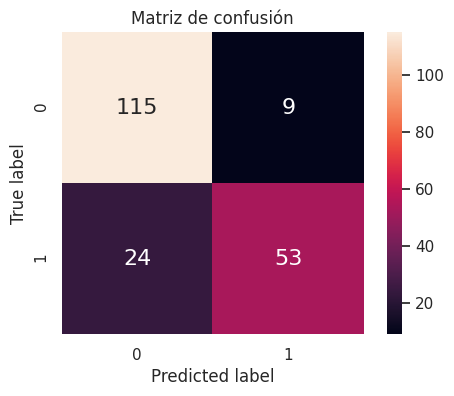

In [53]:
plot_confusion_matrix(y_test_2, ada_2.predict(X_test_2))

## Test Holdout #2

In [56]:
df_h_2 = preprocesado_2(holdout, columnas_nuevas)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,650,1,0,26.0,1,1,0,0
1,1,0,0,234,1,0,8.0,4,1,0,0
2,0,1,0,31,0,0,43.0,3,0,0,0
3,0,0,0,552,0,0,30.0,3,1,0,0
4,1,0,0,411,0,0,32.0,1,1,0,0


In [57]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, ada_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 11) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [58]:
df_resultado_2.to_csv('prediccion/Ada_boosting_2do_prepoc_resultado_final.csv')